In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statistics as stats
from os import listdir
from skimage import io, filters, color,exposure,feature,measure,segmentation
from scipy import ndimage
import cv2 
import imutils
import glob
import sys
sys.path.append('../scripts/')
# from nuclei_segmentation_opencv import nuclei_segmenter
# from nuclei_segmentation import nuclei_segmenter

In [2]:
# seg = nuclei_segmenter(area_threshold=250,p2a_threshold=0.25,solidity_threshold=0.7,median_filter_param=5,cropped_flag=1)
# seg = nuclei_segmenter(area_threshold,p2a_threshold,solidity_threshold,ksize, clipLimit,cropped_flag)
seg = nuclei_segmenter(solidity_threshold=0,cropped_flag=1)
# seg = nuclei_segmenter(area_threshold=250,median_filter_param=0,cropped_flag=0)

In [ ]:
Herlev_df_ext = pd.DataFrame()
folders = listdir('../data/Herlev Database Pictures/')[1:]
for folder in folders:
    for blob in glob.glob('../data/Herlev Database Pictures/{}/*.BMP'.format(folder)):
        df = seg.segment_nuclei(blob)
        df['class'] = folder
        if folder.startswith('normal'):
            df['normal']=1
        else:
            df['normal']=0
        Herlev_df_ext = Herlev_df_ext.append(df)

In [6]:
# Herlev_df_ext.to_pickle('../data/Herlev_df_ext')

In [6]:
Herlev_df_ext = pd.read_pickle('../data/Herlev_df_ext')

In [7]:
len(Herlev_df_ext)

904

(array([824.,  42.,  16.,   8.,   5.,   5.,   1.,   2.,   0.,   1.]),
 array([   302.,  15010.,  29718.,  44426.,  59134.,  73842.,  88550.,
        103258., 117966., 132674., 147382.]),
 <BarContainer object of 10 artists>)

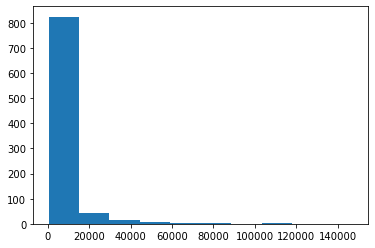

In [8]:
plt.hist(Herlev_df_ext['area'])

In [7]:
from sklearn.model_selection import train_test_split
X = Herlev_df_ext.drop(['class','normal','ctr_score','ID'],axis=1)
X = X.drop(X.filter(regex='^bbox').columns, axis=1)
X = X.drop(X.filter(regex='^centroid').columns, axis=1)
y = Herlev_df_ext['normal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,stratify=y)


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=4,n_informative=2, n_redundant=0,random_state=0, shuffle=False)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)


RandomForestClassifier(max_depth=2, random_state=0)

In [9]:
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve, auc, f1_score

In [10]:
predictions = clf.predict(X_test)
print(f'Classification report: \n{classification_report(y_test,predictions)}')
print()
print(f'Confusion matrix: \n{confusion_matrix(y_test,predictions)}')
print()
# precision recall curve - better than the ROC for unbalanced data
precision, recall, thresholds = precision_recall_curve(y_test,predictions)
print(f'Area under the precision-recall curve: \n{auc(recall,precision)}')

Classification report: 
              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91       200
         1.0       0.89      0.54      0.67        72

    accuracy                           0.86       272
   macro avg       0.87      0.76      0.79       272
weighted avg       0.86      0.86      0.85       272


Confusion matrix: 
[[195   5]
 [ 33  39]]

Area under the precision-recall curve: 
0.7746769162210339


In [11]:
important_features_dict = {}
for x,i in enumerate(clf.feature_importances_):
    important_features_dict[list(X_train.keys())[x]]=i

sorted_features = sorted(important_features_dict.items(), key=lambda kv: kv[1], reverse=True)
from collections import OrderedDict
OrderedDict(sorted_features)

OrderedDict([('major_axis_length', 0.31612077141571815),
             ('area', 0.22588080564823065),
             ('perimeter', 0.17554537889611635),
             ('minor_axis_length', 0.1338332620470843),
             ('max_intensity', 0.06785438868689869),
             ('min_intensity', 0.05378397870730238),
             ('eccentricity', 0.01760677218350451),
             ('solidity', 0.00937464241514493)])

In [13]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(random_state=42,max_iter=500)
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)

In [ ]:
#return image with suspicious nuclei flagged 